# Wine Sales Time Series Forecasting



## Import Dependencies

In [ ]:
# ======================================
# Imports & Data Loading
# ======================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from statsmodels.tsa import tsatools

# Optional: cleaner plots
plt.rcParams["figure.figsize"] = (10, 4)

## Import Data

In [5]:
# Load dataset
dfQ = pd.read_csv(
    "https://raw.githubusercontent.com/qfattah/wine-sales-time-series-forecasting/main/AustralianWines.csv"
)

# Quick sanity check
display(dfQ.head())
display(dfQ.info())
display(dfQ.describe(include="all"))

,Month,Red
0,1/1/1980,464
1,2/1/1980,675
2,3/1/1980,703
3,4/1/1980,887
4,5/1/1980,1139


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   180 non-null    object
 1   Red     180 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ KB


None

,Month,Red
count,180,180.000000
unique,180,NaN
top,1/1/1980,NaN
freq,1,NaN
mean,NaN,1629.727778
std,NaN,614.933333
min,NaN,464.000000
25%,NaN,1123.000000
50%,NaN,1559.000000
75%,NaN,2106.250000


## Data Prep

In [ ]:
# ======================================
# Convert to Time Series
# ======================================

# Convert Month column to datetime (adjust format if your file differs)
dfQ["Date"] = pd.to_datetime(dfQ["Month"], format="%m/%d/%Y")

# Create a time-indexed series for Red wine sales
wine_ts = pd.Series(dfQ["Red"].values, index=dfQ["Date"], name="red").sort_index()

display(wine_ts.head())
display(wine_ts.tail())

Date
1980-01-01     464
1980-02-01     675
1980-03-01     703
1980-04-01     887
1980-05-01    1139
Name: red, dtype: int64

Date
1994-08-01    2665
1994-09-01    2639
1994-10-01    2226
1994-11-01    2586
1994-12-01    2684
Name: red, dtype: int64

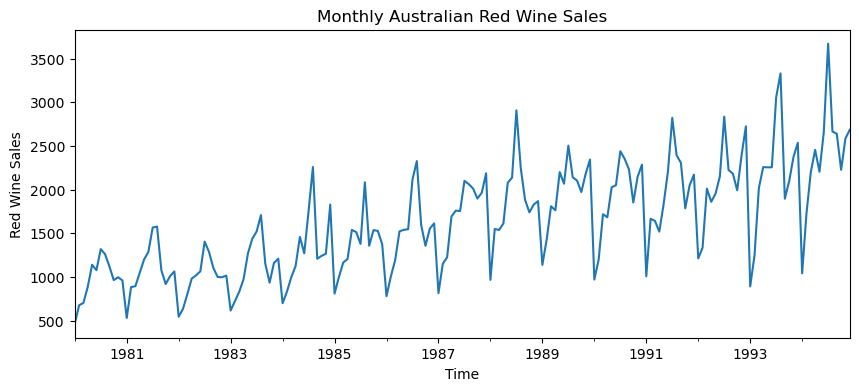

In [7]:
# ======================================
# 3) Visualize the Full Time Series
# ======================================

ax = wine_ts.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Red Wine Sales")
ax.set_title("Monthly Australian Red Wine Sales")
plt.show()

Total observations: 180
Training observations: 156
Validation observations: 24


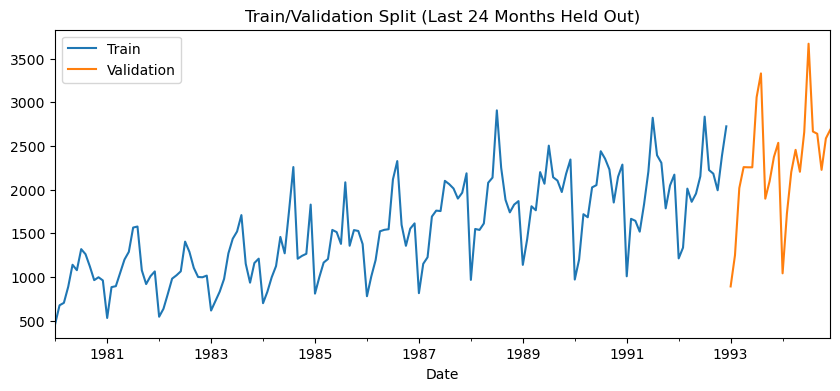

In [ ]:
# ======================================
# Train/Validation Split (Time-Based)
# ======================================

n_valid = 24
n_train = len(wine_ts) - n_valid

train_ts = wine_ts.iloc[:n_train]
valid_ts = wine_ts.iloc[n_train:]

print(f"Total observations: {len(wine_ts)}")
print(f"Training observations: {len(train_ts)}")
print(f"Validation observations: {len(valid_ts)}")

# Plot split
ax = train_ts.plot(label="Train")
valid_ts.plot(ax=ax, label="Validation")
ax.set_title("Train/Validation Split (Last 24 Months Held Out)")
ax.legend()
plt.show()

In [ ]:
# ======================================
# Define Helper Functions: Forecast Error Metrics (No dmba required)
# ======================================

# Calculates key forecast accuracy metrics — MAE, RMSE, and MAPE
def forecast_metrics(y_true, y_pred, label="Model"):
    """
    Compute common forecast error metrics.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    # Avoid divide-by-zero in MAPE
    eps = 1e-9
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

    return pd.Series({"MAE": mae, "RMSE": rmse, "MAPE(%)": mape, "Label": label})

# Creates a clean visualization showing training data, validation data, and model forecasts together, making it easy to visually assess model performance.

def plot_forecast(train, valid, pred, title):
    """
    Plot train series, validation series, and validation predictions.
    """
    ax = train.plot(label="Train")
    valid.plot(ax=ax, label="Validation")
    pd.Series(pred, index=valid.index).plot(ax=ax, label="Forecast")
    ax.set_title(title)
    ax.legend()
    plt.show()

In [ ]:
# ======================================
# Build Modeling DataFrame (Trend + Month)
# ======================================

# Add trend and optional constant to the full series
ts_df = tsatools.add_trend(wine_ts, trend="ct")   # adds const and trend
ts_df["Month"] = ts_df.index.month                # month number (1..12)

# Train/valid split for dataframe version
train_df = ts_df.iloc[:n_train].copy()
valid_df = ts_df.iloc[n_train:].copy()

display(train_df.head())

,red,const,trend,Month
Date,,,,
1980-01-01,464,1.0,1.0,1
1980-02-01,675,1.0,2.0,2
1980-03-01,703,1.0,3.0,3
1980-04-01,887,1.0,4.0,4
1980-05-01,1139,1.0,5.0,5


## Model Building

                            OLS Regression Results                            
Dep. Variable:                    red   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     180.8
Date:                Sun, 22 Feb 2026   Prob (F-statistic):           9.22e-28
Time:                        15:30:29   Log-Likelihood:                -1143.3
No. Observations:                 156   AIC:                             2291.
Df Residuals:                     154   BIC:                             2297.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    831.8371     59.688     13.936      0.0

MAE          427.900652
RMSE         606.820131
MAPE(%)       25.263611
Label      Linear Trend
dtype: object

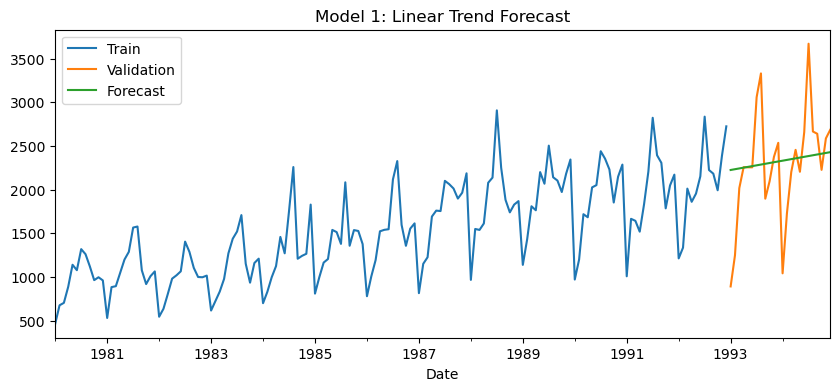

Comment: If the series has strong seasonality, this model often under/over-predicts in recurring months because it only learns the overall trend.


In [11]:
# ======================================
# Model 1: Linear Trend Regression
# ======================================

wine_lm_trend = smf.ols(formula="red ~ trend", data=train_df).fit()
print(wine_lm_trend.summary())

# Forecast on validation horizon
pred_trend = wine_lm_trend.predict(valid_df)

# Evaluate
m1 = forecast_metrics(valid_ts, pred_trend, label="Linear Trend")
display(m1)

# Plot
plot_forecast(train_ts, valid_ts, pred_trend, "Model 1: Linear Trend Forecast")

# Notebook comment after validation:
print("Comment: If the series has strong seasonality, this model often under/over-predicts in recurring months because it only learns the overall trend.")

                            OLS Regression Results                            
Dep. Variable:                    red   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     8.406
Date:                Sun, 22 Feb 2026   Prob (F-statistic):           2.57e-11
Time:                        15:31:39   Log-Likelihood:                -1165.2
No. Observations:                 156   AIC:                             2354.
Df Residuals:                     144   BIC:                             2391.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        811.3077    122.433      6.

MAE              762.285256
RMSE             838.662085
MAPE(%)           31.475947
Label      Seasonality Only
dtype: object

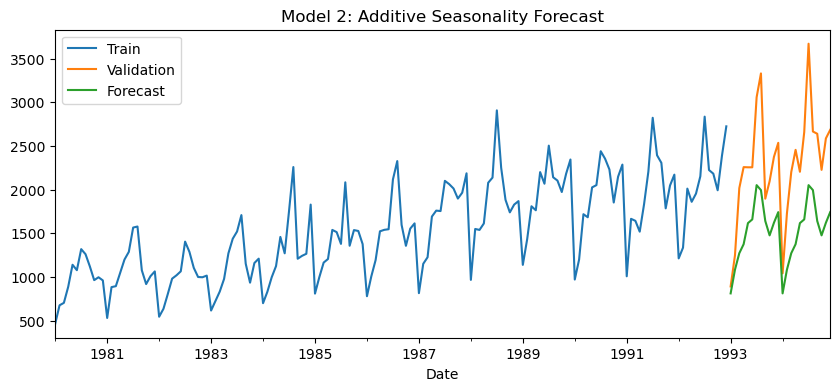

Comment: This model can match seasonal peaks/troughs, but if the overall level is changing over time, it may systematically miss due to ignoring trend.


In [12]:
# Model 2 — Additive Seasonality Regression

#**Formula:** `red ~ C(Month)`  
# Captures recurring month-to-month effects but **does not** model long-run trend.

# ======================================
# Model 2: Additive Seasonality Regression
# ======================================

wine_lm_season = smf.ols(formula="red ~ C(Month)", data=train_df).fit()
print(wine_lm_season.summary())

pred_season = wine_lm_season.predict(valid_df)

m2 = forecast_metrics(valid_ts, pred_season, label="Seasonality Only")
display(m2)

plot_forecast(train_ts, valid_ts, pred_season, "Model 2: Additive Seasonality Forecast")

print("Comment: This model can match seasonal peaks/troughs, but if the overall level is changing over time, it may systematically miss due to ignoring trend.")

                            OLS Regression Results                            
Dep. Variable:                    red   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     93.24
Date:                Sun, 22 Feb 2026   Prob (F-statistic):           2.55e-61
Time:                        15:32:10   Log-Likelihood:                -1034.0
No. Observations:                 156   AIC:                             2094.
Df Residuals:                     143   BIC:                             2134.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        189.2144     58.545      3.

MAE                 257.482448
RMSE                337.713609
MAPE(%)              14.250096
Label      Trend + Seasonality
dtype: object

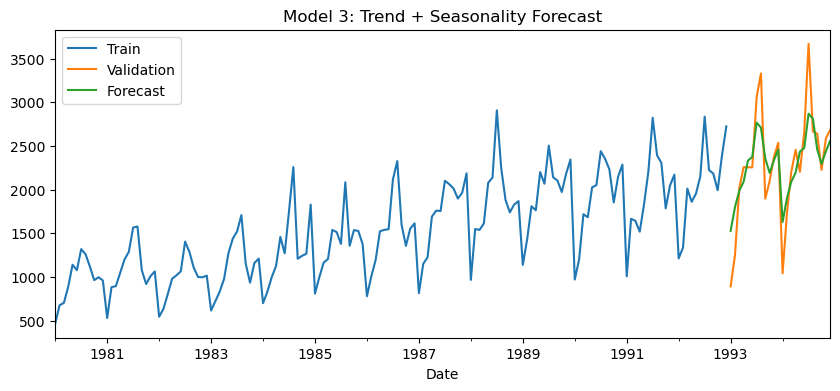

Comment: If both trend and seasonality exist, this model typically improves RMSE/MAPE by capturing level changes and recurring monthly patterns together.


In [13]:
# Model 3 — Trend + Seasonality Regression

# **Formula:** `red ~ trend + C(Month)`  
# Captures both long-run trend and recurring monthly seasonality.
# This is often a strong baseline for seasonal business time series. 

# ======================================
# Model 3: Trend + Seasonality Regression
# ======================================

wine_lm_trendseason = smf.ols(formula="red ~ trend + C(Month)", data=train_df).fit()
print(wine_lm_trendseason.summary())

pred_trendseason = wine_lm_trendseason.predict(valid_df)

m3 = forecast_metrics(valid_ts, pred_trendseason, label="Trend + Seasonality")
display(m3)

plot_forecast(train_ts, valid_ts, pred_trendseason, "Model 3: Trend + Seasonality Forecast")

print("Comment: If both trend and seasonality exist, this model typically improves RMSE/MAPE by capturing level changes and recurring monthly patterns together.")

SES parameters: {'smoothing_level': 0.6492914108141072, 'smoothing_trend': nan, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 553.216753115206, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


c:\Users\qusai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


MAE                  506.651451
RMSE                 688.483375
MAPE(%)               31.783749
Label      Simple Exp Smoothing
dtype: object

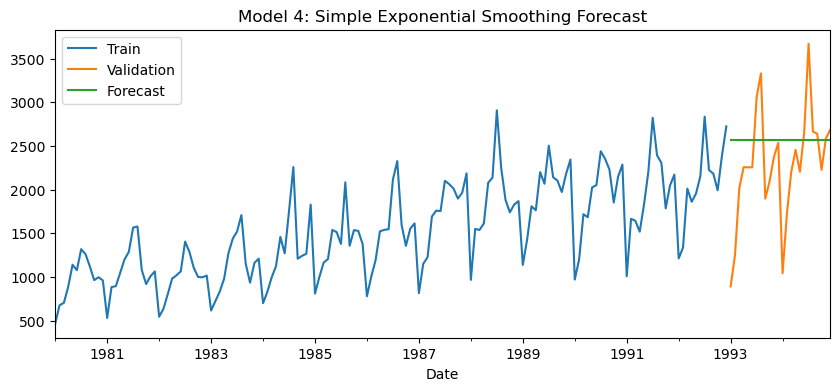

Comment: SES is best when the series is mostly 'level' with noise. If strong seasonality exists, SES may lag during peaks/troughs.


In [14]:
# Model 4 — Simple Exponential Smoothing (SES)

# SES is a smoothing method that **adapts to the level** of the series over time by weighting recent observations more heavily.

# Note: SES does **not** explicitly model trend or seasonality, so it may underperform when those patterns are strong.

# ======================================
# Model 4: Simple Exponential Smoothing (SES)
# ======================================

from statsmodels.tsa.api import SimpleExpSmoothing

ses_model = SimpleExpSmoothing(train_ts, initialization_method="estimated").fit()
pred_ses = ses_model.forecast(len(valid_ts))

print("SES parameters:", ses_model.model.params)

m4 = forecast_metrics(valid_ts, pred_ses, label="Simple Exp Smoothing")
display(m4)

plot_forecast(train_ts, valid_ts, pred_ses, "Model 4: Simple Exponential Smoothing Forecast")

print("Comment: SES is best when the series is mostly 'level' with noise. If strong seasonality exists, SES may lag during peaks/troughs.")

## Model Validation

In [15]:
# ======================================
# Model Comparison Table
# ======================================

comparison = pd.DataFrame([m1, m2, m3, m4]).set_index("Label")[["MAE", "RMSE", "MAPE(%)"]]
display(comparison.sort_values("RMSE"))

,MAE,RMSE,MAPE(%)
Label,,,
Trend + Seasonality,257.482448,337.713609,14.250096
Linear Trend,427.900652,606.820131,25.263611
Simple Exp Smoothing,506.651451,688.483375,31.783749
Seasonality Only,762.285256,838.662085,31.475947


Best model by RMSE: Trend + Seasonality


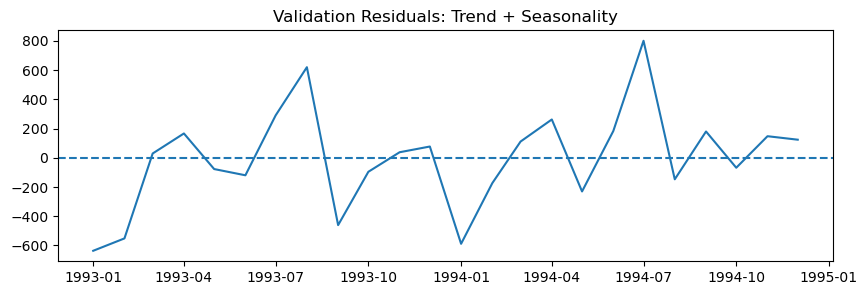

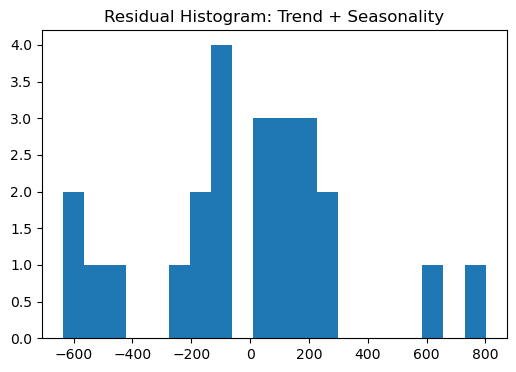

Comment: If residuals show clear seasonality or drift, the model is missing structure (often indicates need for Holt-Winters or SARIMA).


In [16]:
# ======================================
# Residual Plots for Best Model (by RMSE)
# ======================================

best_label = comparison["RMSE"].idxmin()
print("Best model by RMSE:", best_label)

pred_map = {
    "Linear Trend": pred_trend,
    "Seasonality Only": pred_season,
    "Trend + Seasonality": pred_trendseason,
    "Simple Exp Smoothing": pred_ses,
}

best_pred = pred_map[best_label]
resid = valid_ts - np.asarray(best_pred)

plt.figure(figsize=(10, 3))
plt.plot(valid_ts.index, resid)
plt.title(f"Validation Residuals: {best_label}")
plt.axhline(0, linestyle="--")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(resid, bins=20)
plt.title(f"Residual Histogram: {best_label}")
plt.show()

print("Comment: If residuals show clear seasonality or drift, the model is missing structure (often indicates need for Holt-Winters or SARIMA).")